In [64]:
import pandas as pd
import re
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [65]:
df = pd.read_csv("Data/DF_Combined_2025_1h_Processed.csv")
df['volume_z'] = df.groupby('coin')['volume'].transform(
    lambda x: (x - x.mean()) / x.std()
)
df['volume_change'] = df.groupby('coin')['volume'].pct_change()
df = df.dropna()
df.head()

,coin,date,RET,close,high,low,open,volume,volume_z,volume_change
1,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,313.72000,308.72000,308.73000,27473.90000,-0.44968,0.65808
2,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,314.28000,311.37000,313.61000,23172.20000,-0.56272,-0.15657
3,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,316.92000,313.21000,313.37000,26176.50000,-0.48377,0.12965
4,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,314.58000,311.81000,314.53000,13005.10000,-0.82987,-0.50318
5,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,313.19000,309.72000,312.20000,17516.70000,-0.71132,0.34691


In [66]:
df[['RET', 'volume_z', 'volume_change']].corr()


,RET,volume_z,volume_change
RET,1.00000,0.00615,-0.00451
volume_z,0.00615,1.00000,0.44170
volume_change,-0.00451,0.44170,1.00000


### Money Flow Index (MFI)

The **Money Flow Index (MFI)** is a *volume-weighted momentum indicator* that measures buying and selling pressure.  
It combines **price** and **volume** to show whether money is flowing **into** or **out of** an asset.

---

### How it works
- When price and volume both rise → **Positive Money Flow** (buying pressure).  
- When price rises but volume drops → **Weak Money Flow** (trend losing strength).  
- When price and volume both fall → **Negative Money Flow** (selling pressure).  

The MFI oscillates between **0 and 100**:
- **MFI > 80** → Overbought → possible downward reversal.  
- **MFI < 20** → Oversold → possible upward reversal.  

---

### Why it’s useful
Unlike RSI, which uses only price, MFI includes **volume**, making it more reliable for detecting:
- **Trend exhaustion**
- **Divergences** between price and money flow
- **Potential reversal points** before they appear in price.


In [67]:
def add_mfi_features(df: pd.DataFrame, windows=(14, 28, 50, 75, 100)) -> pd.DataFrame:
    """
    Adds MFI_{window} per coin. Keeps the 'coin' column.
    Requires columns: ['coin','date','high','low','close','volume'].
    """
    out = df.copy()
    if not np.issubdtype(out['date'].dtype, np.datetime64):
        out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out.sort_values(['coin', 'date'], inplace=True)

    def _compute(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        # reattach coin explicitly (group key)
        g['coin'] = group.name

        tp = (g['high'] + g['low'] + g['close']) / 3.0               # typical price
        mf = tp * g['volume']                                        # raw money flow

        up_flow   = np.where(tp > tp.shift(1), mf, 0.0)
        down_flow = np.where(tp < tp.shift(1), mf, 0.0)

        up_s  = pd.Series(up_flow, index=g.index)
        dn_s  = pd.Series(down_flow, index=g.index)

        for w in windows:
            up_sum = up_s.rolling(w, min_periods=w).sum()
            dn_sum = dn_s.rolling(w, min_periods=w).sum()
            mfi = 100.0 * (up_sum / (up_sum + dn_sum + 1e-12))
            g[f"MFI_{w}"] = mfi

        return g

    # include_groups=False removes the 'coin' column from the slice; we add it back above
    out = out.groupby('coin', group_keys=False).apply(_compute, include_groups=False)
    return out

# Example usage
df = add_mfi_features(df, windows=(7, 14, 24, 24*3, 24*5, 24*7, 24*14, 24*30))
df = df.dropna()
df.head()


,date,RET,close,high,low,open,volume,volume_z,volume_change,coin,MFI_7,MFI_14,MFI_24,MFI_72,MFI_120,MFI_168,MFI_336,MFI_720
720,2025-01-30 23:00:00,-0.00574,315.36000,319.48000,315.13000,317.18000,15502.90000,-0.76424,0.62635,AAVEUSDT,45.83148,63.70193,69.78539,54.98108,50.69735,48.52804,52.35545,51.20568
721,2025-01-31 00:00:00,0.00999,318.51000,318.63000,313.26000,315.36000,25200.60000,-0.50942,0.62554,AAVEUSDT,47.45818,63.68207,74.56711,56.08476,50.76109,49.07325,52.37237,51.24502
722,2025-01-31 01:00:00,0.00546,320.25000,320.41000,316.68000,318.50000,20953.70000,-0.62101,-0.16852,AAVEUSDT,62.03413,62.25010,74.18358,57.14448,51.20302,49.47103,52.29083,51.24223
723,2025-01-31 02:00:00,-0.00987,317.09000,320.75000,315.63000,320.25000,18808.80000,-0.67737,-0.10236,AAVEUSDT,47.86573,64.90605,71.33125,56.35625,51.22370,49.53734,51.98588,51.17069
724,2025-01-31 03:00:00,-0.00369,315.92000,317.60000,314.00000,317.07000,22673.20000,-0.57583,0.20546,AAVEUSDT,53.16365,56.08733,67.75794,55.45892,50.65738,48.89632,51.98633,51.15471


In [68]:
# Define the look-ahead periods (in hours)
HORIZONS = [1, 2, 5, 10, 24, 24*3, 24*5, 24*7, 24*14, 24*30]

# 1. Create the future return columns
for h in HORIZONS:
    # Column name will be 'Future_RET_H' where H is the horizon
    col_name = f'Future_RET_{h}H'
    
    
    # --- Correct approach for cumulative future return (Gross Return Product) ---
    def calculate_future_cumulative_return(group, hours):
        # Calculate the cumulative gross return (1 + R_t) * (1 + R_t+1) ... (1 + R_t+h-1)
        gross_return = (1 + group['RET']).rolling(window=hours).apply(lambda x: x.prod(), raw=True)
        # Shift back by 'hours' and subtract 1 to get the simple cumulative return from t to t+h
        future_return = gross_return.shift(-hours) - 1
        return future_return

    df[col_name] = df.groupby('coin').apply(
        lambda x: calculate_future_cumulative_return(x, h), 
        include_groups=False
    ).reset_index(level=0, drop=True)
    

# Drop rows where the target return cannot be calculated (at the end of the time series)
df = df.dropna(subset=[f'Future_RET_{h}H' for h in HORIZONS])
df.head()

,date,RET,close,high,low,open,volume,volume_z,volume_change,coin,MFI_7,MFI_14,MFI_24,MFI_72,MFI_120,MFI_168,MFI_336,MFI_720,Future_RET_1H,Future_RET_2H,Future_RET_5H,Future_RET_10H,Future_RET_24H,Future_RET_72H,Future_RET_120H,Future_RET_168H,Future_RET_336H,Future_RET_720H
720,2025-01-30 23:00:00,-0.00574,315.36000,319.48000,315.13000,317.18000,15502.90000,-0.76424,0.62635,AAVEUSDT,45.83148,63.70193,69.78539,54.98108,50.69735,48.52804,52.35545,51.20568,0.00999,0.01551,-0.00907,0.00821,0.05467,-0.18119,-0.13753,-0.23478,-0.18747,-0.38185
721,2025-01-31 00:00:00,0.00999,318.51000,318.63000,313.26000,315.36000,25200.60000,-0.50942,0.62554,AAVEUSDT,47.45818,63.68207,74.56711,56.08476,50.76109,49.07325,52.37237,51.24502,0.00546,-0.00446,-0.00097,-0.00681,0.04000,-0.21889,-0.15943,-0.24351,-0.20134,-0.38956
722,2025-01-31 01:00:00,0.00546,320.25000,320.41000,316.68000,318.50000,20953.70000,-0.62101,-0.16852,AAVEUSDT,62.03413,62.25010,74.18358,57.14448,51.20302,49.47103,52.29083,51.24223,-0.00987,-0.01352,0.00550,0.01686,0.02948,-0.32053,-0.16465,-0.23663,-0.20322,-0.39500
723,2025-01-31 02:00:00,-0.00987,317.09000,320.75000,315.63000,320.25000,18808.80000,-0.67737,-0.10236,AAVEUSDT,47.86573,64.90605,71.33125,56.35625,51.22370,49.53734,51.98588,51.17069,-0.00369,-0.01448,0.00779,0.03589,0.04084,-0.31496,-0.15122,-0.22221,-0.19118,-0.38888
724,2025-01-31 03:00:00,-0.00369,315.92000,317.60000,314.00000,317.07000,22673.20000,-0.57583,0.20546,AAVEUSDT,53.16365,56.08733,67.75794,55.45892,50.65738,48.89632,51.98633,51.15471,-0.01083,0.00722,0.00165,0.03349,0.03191,-0.27314,-0.15824,-0.22123,-0.17688,-0.38532


In [ ]:
def _natural_sort_by_number(cols, prefix):
    """Sort columns like 'MFI_7','MFI_14' or 'Future_RET_10H' by the number."""
    def key(c):
        if not c.startswith(prefix):
            return (10**9, c)
        m = re.search(r'(\d+)', c)
        return (int(m.group(1)) if m else 10**9, c)
    return sorted([c for c in cols if c.startswith(prefix)], key=key)

def plot_mfi_corr(
    df: pd.DataFrame,
    coin: str = "all",
    mfi_prefix: str = "MFI_",
    target_prefix: str = "Future_RET_",
    figsize=(9, 6),
    annotate: bool = True,
    cmap: str = None
):
    """
    Plot correlation between MFI features and future returns, per coin or averaged across coins.
    Returns the (rows=MFI windows, cols=future-return horizons) correlation matrix.
    """
    if "coin" not in df.columns:
        raise ValueError("DataFrame must contain a 'coin' column.")

    mfi_cols    = _natural_sort_by_number(df.columns, mfi_prefix)
    target_cols = _natural_sort_by_number(df.columns, target_prefix)
    if not mfi_cols:
        raise ValueError(f"No MFI columns found starting with '{mfi_prefix}'.")
    if not target_cols:
        raise ValueError(f"No target columns found starting with '{target_prefix}'.")

    coins = [coin] if coin != "all" else df["coin"].dropna().unique().tolist()
    if not coins:
        raise ValueError("No coins found.")

    blocks = []
    for c in coins:
        sub = df[df["coin"] == c]
        if sub.empty:
            continue
        corr = sub.loc[:, mfi_cols + target_cols].corr()
        blocks.append(corr.reindex(index=mfi_cols, columns=target_cols))

    if not blocks:
        raise ValueError(f"No data for coin(s): {coins}")

    if coin == "all":
        aligned = [b.reindex(index=mfi_cols, columns=target_cols) for b in blocks]
        key_corr = (
            pd.concat(aligned, keys=range(len(aligned)))
              .groupby(level=1).mean()
              .reindex(index=mfi_cols, columns=target_cols)
        )
        title = "All Coins (Average)"
    else:
        key_corr = blocks[0]
        title = coin

    vals = key_corr.to_numpy()
    vals_disp = np.nan_to_num(vals, nan=0.0)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(vals_disp, aspect="auto", vmin=-1, vmax=1, cmap=cmap)

    ax.set_yticks(range(len(mfi_cols)));  ax.set_yticklabels(mfi_cols)
    ax.set_xticks(range(len(target_cols))); ax.set_xticklabels(target_cols, rotation=45, ha="right")

    ax.set_title(f"Correlation: MFI vs Future Returns — {title}")
    ax.set_xlabel("Future Return Targets")
    ax.set_ylabel("MFI Windows")

    cbar = fig.colorbar(im, ax=ax); cbar.set_label("Correlation")

    if annotate:
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = key_corr.iat[i, j]
                ax.text(j, i, ("nan" if pd.isna(v) else f"{v:.2f}"),
                        ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()
    return key_corr

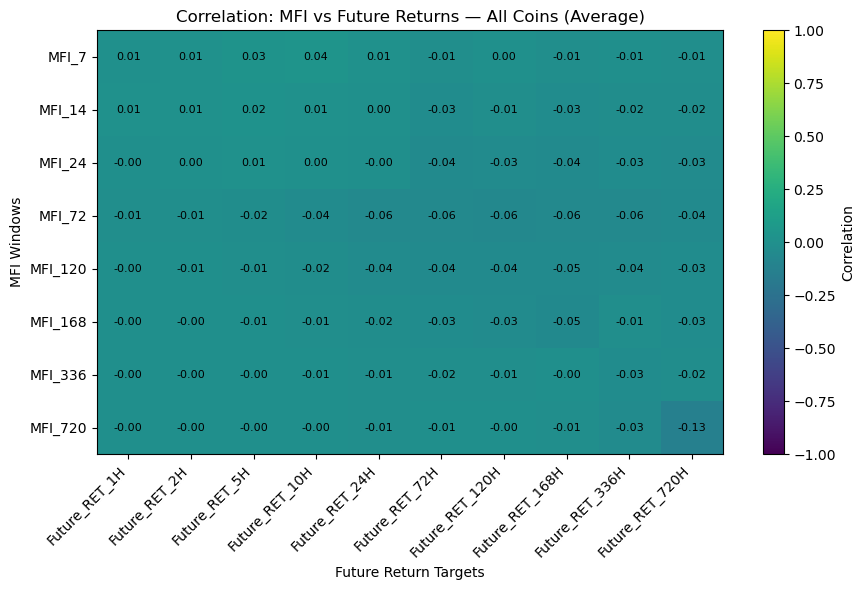

In [70]:
# Average across all coins
_ = plot_mfi_corr(df, coin="all")
